# Практические задание к Модулю  3.

Предлагаем вам решить практическое задание с использованием Transformer и сравнить полученные оценки качества.
<hr>

**Критерии оценивания проекта:**

- общее качество кода и следование PEP-8;
- [x] использование рекуррентных сетей (в ноутбуке с рекуррентной сетью [здесь](https://www.kaggle.com/code/katyashakhova/lstm-classifier-baseline))
- [x] использованы варианты архитектур, близкие к state of the art для данной задачи (в этом ноутбуке)
- [x] произведен подбор гиперпараметров (в цикле перебираю learning rate, weight decay + batch size для модели roberta-base);
- [x] использованы техники изменения learning rate (lr scheduler) (в ноутбуке с рекуррентной сетью [здесь](https://www.kaggle.com/code/katyashakhova/lstm-classifier-baseline) + использую его как аргумент для trainer)
- [x] использована адекватная задаче функция потерь;
- [x] использованы техники регуляризации (использовался weight decay)
- [x] корректно проведена валидация модели;
- [ ] использованы техники ensemble (не использовала, не нашла применения, модель Bert с измененной 'головой' не обучилась)
- [ ] использованы дополнительные данные (не использовала, так как не поняла как)
- [x] итоговое значение метрики качества > 0.7.
<hr>

## План решения задачи

1. Сдeлаю классификацию с помощью LSTM, буду ее использовать как baseline. Решение с помощью рекуррентых сетей [здесь](https://www.kaggle.com/code/katyashakhova/lstm-classifier-baseline). Тестовые данные проверены на kuggle.  **Лучшая метрика 0,7661 по рекуррентным сетям.**

2. Посмотрю, как на результаты классификации влияет learning rate, batch size и weight decay на примере одной модели. Возьму roberta-base для примера. Такой анализ вот в этом [ноутбуке](https://www.kaggle.com/code/katyashakhova/roberta-classif). Оказалось, что разница может быть существенной. Для лучших показателей сделала submission тестовых данных, результат зафиксирован в ноутбуке. При этом данные были обработаны также, как и для рекуррентных сетей. **Лучшая метрика 0,8196 по данному ноутбуку.**

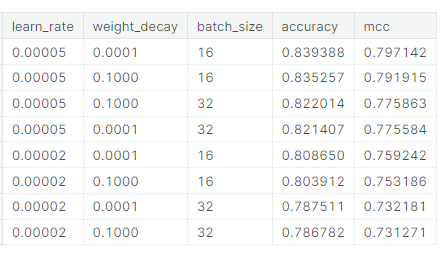 



3. Попробую НЕ обработанные данные, а также разные модели, как энкодерные, так и генеративную (T5). Буду добавлять в аргументы trainer с hugging face шедьюлер + weight decay модификация обучения и сравню результаты.




### Результаты сравнения моделей на тестовых данных при сдачи в соревновании [kuggle](https://www.kaggle.com/competitions/unit-3-nlp-txt-classification/leaderboard) 

In [62]:
results.sort_values(by = 'kuggle_res', ascending = False)

,model,modif,kuggle_res
4,bert base,with scheduler,0.87309
3,Electra base,with scheduler,0.86308
5,distilbert-base,with scheduler,0.85571
2,Electra base,no,0.85229
0,Roberta base,no,0.83912
1,Roberta base,with scheduler,0.83201
6,T5,adafactor + scheduler,0.82727


## Финальные выводы:

Лучше всех оказался старый-добрый Bert base uncased, добавление scheduler позволило повысить точность классификации. Хуже всех справилась генеративная модель, но в любом случае лучше, чем LSTM.

Основной вывод - трансформерные SOTA модели рулят в задачах NLP и их результат без finetune намного лучше, чем у рекуррентных сетей.

# 1.EDA и подготовка данных. 

Предобработаем данные в том же порядке, как и для рекуррентных сетей. Далее соберем их в Dataset и переведем в эмбеддинги.

In [54]:
results = pd.DataFrame()

In [1]:
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import re
from datasets import Dataset, DatasetDict
import datasets
from transformers import Trainer, TrainingArguments, set_seed
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from transformers import DataCollatorWithPadding
import evaluate
from transformers import EvalPrediction
import os


In [2]:
train = pd.read_csv('train.csv', index_col = 0)
train = train.dropna()
train.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
test = pd.read_csv('test.csv')
test.head(5)

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [4]:
def label_coversion(text):
    if text == 'Extremely Negative':
        return 0
    elif text == 'Negative':
        return 1
    elif text == 'Neutral':
        return 2
    elif text == 'Positive':
        return 3
    else:
        return 4

In [5]:
train['text'] = train['Text']
test_upd = test[['Text']]
test_upd['label'] = ''
test_upd['text'] = test_upd['Text']
train['label'] = train['Sentiment'].apply(lambda x: label_coversion(x))
df_train, df_valid= train_test_split(train[['text', 'label']], test_size=0.2)
test_upd = test_upd[['text', 'label']]

In [6]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop = True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop = True)),
    'test': Dataset.from_pandas(test_upd)
    })
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3798
    })
})

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
def preprocess_data(examples):
     
    encoding = tokenizer(examples['text'])
    return encoding

In [9]:
ACCURACY = evaluate.load("accuracy")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {"accuracy": acc_result["accuracy"], "mcc": mcc_result["matthews_correlation"]}

    return result

# а. Roberta from box

In [10]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text'])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3798
    })
})

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Roberta",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.698900,0.713018,0.706111,0.641231
2,0.441900,0.468111,0.842303,0.799576
3,0.270600,0.475973,0.859191,0.821147


TrainOutput(global_step=6174, training_loss=0.5800318215941395, metrics={'train_runtime': 729.5503, 'train_samples_per_second': 135.388, 'train_steps_per_second': 8.463, 'total_flos': 3066150659511288.0, 'train_loss': 0.5800318215941395, 'epoch': 3.0})

In [12]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

Результаты на Kaggle:

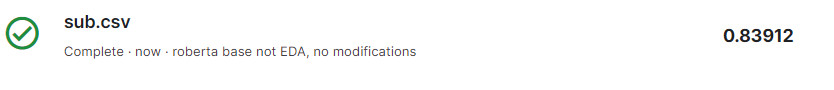

In [55]:
row = {'model': 'Roberta base',
      'modif': 'no',
      'kuggle_res': 0.83912}

results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

# b. Roberta with l_r scheduler

In [15]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Roberta",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1,
    num_train_epochs=3,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    optim="adamw_torch",
    save_strategy="no",
    save_total_limit=1,
    seed=0,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.726300,0.627264,0.765035,0.701570
2,0.455100,0.489398,0.827846,0.783904
3,0.282500,0.490947,0.846556,0.805649


TrainOutput(global_step=6174, training_loss=0.5938099705752022, metrics={'train_runtime': 725.4086, 'train_samples_per_second': 136.161, 'train_steps_per_second': 8.511, 'total_flos': 3067114740830160.0, 'train_loss': 0.5938099705752022, 'epoch': 3.0})

In [16]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

Результаты на Kuggle:

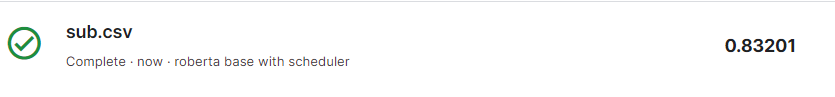

In [56]:
row = {'model': 'Roberta base',
      'modif': 'with scheduler',
      'kuggle_res': 0.83201}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

# с. Electra base out of box

https://huggingface.co/docs/transformers/model_doc/electra

ELECTRA is a new pretraining approach which trains two transformer models: the generator and the discriminator. The generator’s role is to replace tokens in a sequence, and is therefore trained as a masked language model.


In [17]:
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text'])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3798
    })
})

In [18]:
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Roberta",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.1,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.613800,0.740787,0.715466,0.653518
2,0.383300,0.442181,0.849107,0.809879
3,0.241500,0.445530,0.869518,0.834725


TrainOutput(global_step=6174, training_loss=0.5358668865800715, metrics={'train_runtime': 686.1364, 'train_samples_per_second': 143.954, 'train_steps_per_second': 8.998, 'total_flos': 2875227612996336.0, 'train_loss': 0.5358668865800715, 'epoch': 3.0})

In [19]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

Результаты на kuggle:

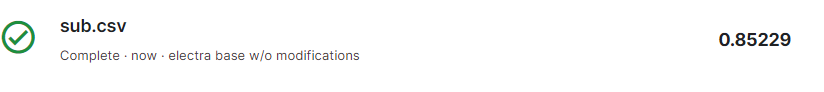

In [57]:
row = {'model': 'Electra base',
      'modif': 'no',
      'kuggle_res': 0.85229}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

# d. Electra base with scheduler

In [20]:
model = AutoModelForSequenceClassification.from_pretrained("google/electra-base-discriminator", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Roberta",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.001,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.629900,0.566364,0.797959,0.746048
2,0.393100,0.419002,0.861256,0.824162
3,0.243900,0.462275,0.867574,0.832134


TrainOutput(global_step=6174, training_loss=0.5371107583992837, metrics={'train_runtime': 682.3011, 'train_samples_per_second': 144.763, 'train_steps_per_second': 9.049, 'total_flos': 2875227612996336.0, 'train_loss': 0.5371107583992837, 'epoch': 3.0})

In [21]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

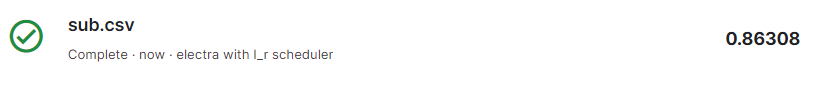

In [58]:
row = {'model': 'Electra base',
      'modif': 'with scheduler',
      'kuggle_res': 0.86308}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

# e. Bert -base with scheduler

In [10]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text'])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3798
    })
})

In [11]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Models",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.001,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.560700,0.479403,0.828089,0.782465
2,0.339100,0.401543,0.871462,0.837041
3,0.183400,0.468703,0.875471,0.842170


TrainOutput(global_step=6174, training_loss=0.47988394591118627, metrics={'train_runtime': 645.0541, 'train_samples_per_second': 153.122, 'train_steps_per_second': 9.571, 'total_flos': 2873474177250072.0, 'train_loss': 0.47988394591118627, 'epoch': 3.0})

In [12]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

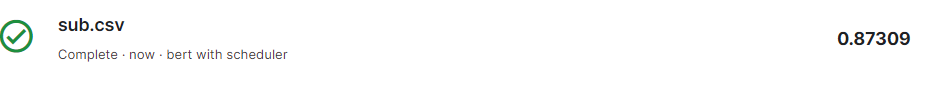

In [59]:
row = {'model': 'bert base',
      'modif': 'with scheduler',
      'kuggle_res': 0.87309}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

# f. Distilbert-base

In [13]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding = True)

encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text'])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/32924 [00:00<?, ? examples/s]

Map:   0%|          | 0/8231 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 32924
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 8231
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3798
    })
})

In [14]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 5)

training_args = TrainingArguments(
    output_dir=f"Models",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.001,
    num_train_epochs=3,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    save_strategy="no",
    save_total_limit=1,
    group_by_length=True,
    report_to="none",

)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifi

Epoch,Training Loss,Validation Loss,Accuracy,Mcc
1,0.560200,0.556489,0.792735,0.741897
2,0.342400,0.388121,0.861256,0.824491
3,0.194800,0.430758,0.874377,0.840794


TrainOutput(global_step=6174, training_loss=0.4666753181331475, metrics={'train_runtime': 351.1311, 'train_samples_per_second': 281.297, 'train_steps_per_second': 17.583, 'total_flos': 1446734194803480.0, 'train_loss': 0.4666753181331475, 'epoch': 3.0})

In [15]:
test_dataset = encoded_dataset['test'].remove_columns(['labels'])
predictions = trainer.predict(test_dataset=test_dataset)
preds = []
for item in predictions.predictions:
    preds.append(np.argmax(item))
test['preds'] = preds

def pred_conversion(text):

    if text == 0:
        return 'Extremely Negative'
    elif text == 1:
        return 'Negative'
    elif text == 2:
        return 'Neutral'
    elif text == 3:
        return 'Positive'
    else:
        return 'Extremely Positive'

test['Sentiment'] = test['preds'].apply(lambda x: pred_conversion(x))

sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

In [60]:
row = {'model': 'distilbert-base',
      'modif': 'with scheduler',
      'kuggle_res': 0.85571}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

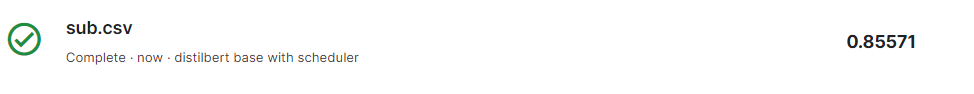


# g. T5 base fine tune

In [2]:
train = pd.read_csv('train.csv', index_col = 0)
train = train.dropna()
train.head(5)

,Text,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
test = pd.read_csv('test.csv')
test.head(5)

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [4]:
train['text'] = train['Text']
test_upd = test[['Text']]
test_upd['label'] = ''
test_upd['text'] = test_upd['Text']
train['label'] = train['Sentiment']
df_train, df_valid= train_test_split(train[['text', 'label']], test_size=0.1)
test_upd = test_upd[['text', 'label']]

dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop = True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop = True)),
    'test': Dataset.from_pandas(test_upd)
    })
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 37039
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 4116
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3798
    })
})

In [5]:
def preprocess_data(examples):
     
    sentence = tokenizer(examples['text'])
    labels = tokenizer(examples['label'])
    return {"input_ids":sentence['input_ids'], "labels":labels['input_ids']}


tokenizer = AutoTokenizer.from_pretrained("t5-base")


encoded_dataset = dataset.map(preprocess_data, batched = True)
encoded_dataset = encoded_dataset.remove_columns(['text', 'label'])
#encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/37039 [00:00<?, ? examples/s]

Map:   0%|          | 0/4116 [00:00<?, ? examples/s]

Map:   0%|          | 0/3798 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 37039
    })
    valid: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 4116
    })
    test: Dataset({
        features: ['input_ids', 'labels'],
        num_rows: 3798
    })
})

In [6]:
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    evaluation_strategy = 'epoch',  
    learning_rate = 2e-4,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    weight_decay = 0.01,
    optim = "adafactor",
    num_train_epochs = 3,
    predict_with_generate = True,
    push_to_hub = False, 
    lr_scheduler_type = "cosine",
    output_dir = "outputs",
    warmup_ratio=0.1
    
)

In [7]:
from transformers import AutoModelForSeq2SeqLM
from transformers import DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")
data_collator = DataCollatorForSeq2Seq(tokenizer, model = model)

In [8]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(model,
                        args,
                        train_dataset = encoded_dataset['train'],
                        eval_dataset = encoded_dataset['valid'],
                        data_collator = data_collator,
                        tokenizer = tokenizer,
                        )

trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.215900,0.194892
2,0.129500,0.133859
3,0.079600,0.134958


TrainOutput(global_step=6945, training_loss=0.25665222508517677, metrics={'train_runtime': 1640.2219, 'train_samples_per_second': 67.745, 'train_steps_per_second': 4.234, 'total_flos': 1.343855528050176e+16, 'train_loss': 0.25665222508517677, 'epoch': 3.0})

In [11]:
from tqdm import tqdm_notebook
predictions = []
for ind in tqdm_notebook(range(len(encoded_dataset['valid']))):
    preds = model.generate(input_ids = torch.tensor(encoded_dataset['valid'][ind]['input_ids'], dtype = torch.long).to(device).view(1,-1))
    pred_str = tokenizer.decode(np.array(preds.cpu()[0]))
    fin = re.sub(re.compile('\<(.*?)\>'), '', pred_str).strip()
    predictions.append(fin)

  0%|          | 0/4116 [00:00<?, ?it/s]

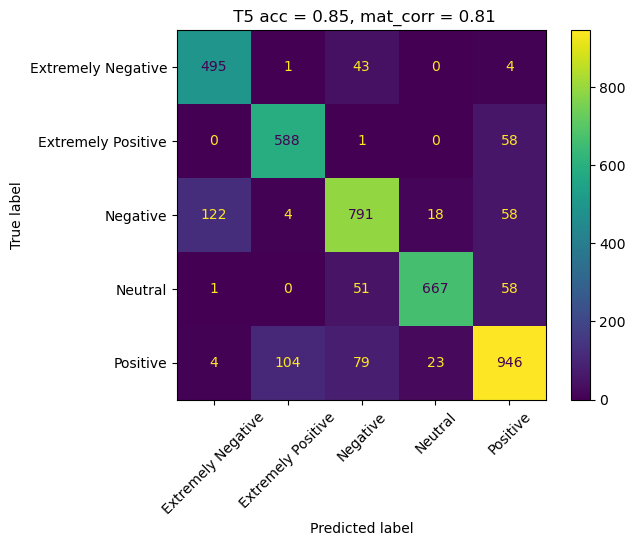

In [12]:
import matplotlib.pyplot as plt
from sklearn import metrics
metrics.ConfusionMatrixDisplay.from_predictions(dataset['valid']['label'], predictions)
plt.title(f" T5 acc = {round(metrics.accuracy_score(dataset['valid']['label'], predictions), 2)}, mat_corr = {round(metrics.matthews_corrcoef(dataset['valid']['label'], predictions), 2)}")
plt.xticks(rotation = 45);

In [13]:
res = []
for ind in tqdm_notebook(range(len(encoded_dataset['test']))):
    preds = model.generate(input_ids = torch.tensor(encoded_dataset['test'][ind]['input_ids'], dtype = torch.long).to(device).view(1,-1))
    pred_str = tokenizer.decode(np.array(preds.cpu()[0]))
    fin = re.sub(re.compile('\<(.*?)\>'), '', pred_str).strip()
    res.append(fin)

  0%|          | 0/3798 [00:00<?, ?it/s]

In [14]:
test['Sentiment'] = res
test

,id,Text,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...,Extremely Positive
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...,Negative
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
...,...,...,...
3793,65712d27-5c41-4863-b74f-0bd66199b7df,Meanwhile In A Supermarket in Israel -- People...,Positive
3794,9fd189c5-e79c-49d7-8985-576450a4e6e3,Did you panic buy a lot of non-perishable item...,Negative
3795,3a06785f-6f9b-4f4d-9880-22562ad3e296,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral
3796,dd29ff09-9bc2-40f4-8201-4b6361aca760,Gov need to do somethings instead of biar je r...,Extremely Negative


In [15]:
sub = test[['id', 'Sentiment']]
sub.to_csv('sub.csv',index = False )

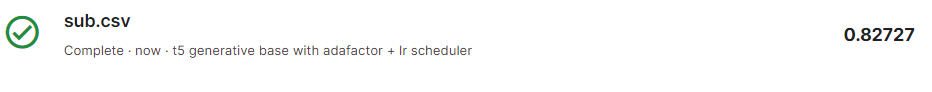

In [61]:
row = {'model': 'T5',
      'modif': 'adafactor + scheduler',
      'kuggle_res': 0.82727}
results = pd.concat([results, pd.DataFrame([row])], ignore_index = True)

## Финальные выводы:

Лучше всех оказался старый-добрый Bert base uncased, добавление scheduler позволило повысить точность классификации. Хуже всех справилась генеративная модель, но в любом случае лучше, чем LSTM.

Основной вывод - трансформерные SOTA модели рулят в задачах NLP и их результат без finetune намного лучше, чем у рекуррентных сетей.